In [1]:
# Importar librerías necesarias
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
#!pip3 install joblib
import joblib

# List of URLs of the datasets
urls = [
    "https://www.football-data.co.uk/mmz4281/2425/E0.csv",
    "https://www.football-data.co.uk/mmz4281/2324/E0.csv",
    "https://www.football-data.co.uk/mmz4281/2223/E0.csv",
    "https://www.football-data.co.uk/mmz4281/2122/E0.csv",
    "https://www.football-data.co.uk/mmz4281/2021/E0.csv",
    "https://www.football-data.co.uk/mmz4281/1920/E0.csv",
]

## Cargar Datos

In [2]:
# Cargar todos los CSVs
dfs = [pd.read_csv(url) for url in urls]

# Visualizar las primeras filas de cada dataset para inspeccionar la estructura
for i, df in enumerate(dfs):
    print(f"DataFrame {i+1}:")
    print(df.head(), "\n")

DataFrame 1:
  Div        Date   Time    HomeTeam     AwayTeam  FTHG  FTAG FTR  HTHG  HTAG  \
0  E0  16/08/2024  20:00  Man United       Fulham     1     0   H     0     0   
1  E0  17/08/2024  12:30     Ipswich    Liverpool     0     2   A     0     0   
2  E0  17/08/2024  15:00     Arsenal       Wolves     2     0   H     1     0   
3  E0  17/08/2024  15:00     Everton     Brighton     0     3   A     0     1   
4  E0  17/08/2024  15:00   Newcastle  Southampton     1     0   H     1     0   

   ... B365CAHH B365CAHA  PCAHH  PCAHA  MaxCAHH  MaxCAHA  AvgCAHH  AvgCAHA  \
0  ...     1.86     2.07   1.83   2.11     1.88     2.11     1.82     2.05   
1  ...     2.05     1.88   2.04   1.90     2.20     2.00     1.99     1.88   
2  ...     2.02     1.91   2.00   1.90     2.05     1.93     1.99     1.87   
3  ...     1.87     2.06   1.86   2.07     1.92     2.10     1.83     2.04   
4  ...     1.87     2.06   1.88   2.06     1.89     2.10     1.82     2.05   

   BFECAHH  BFECAHA  
0     1.9

## Unir DataFrames

In [3]:
# Unir todos los DataFrames en uno solo
matches = pd.concat(dfs, ignore_index=True)

# Verificar el tamaño del DataFrame combinado
print(matches.shape)

(2020, 132)


In [4]:
# Load and preprocess the dataset
def load_and_preprocess_data():
    # Create features
    matches['goal_difference'] = matches['FTHG'] - matches['FTAG']
    matches['HF'] = matches.groupby('HomeTeam')['goal_difference'].rolling(5).mean().reset_index(level=0, drop=True)
    matches['AF'] = matches.groupby('AwayTeam')['goal_difference'].rolling(5).mean().reset_index(level=0, drop=True)

    features = ['FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'HF', 'AF', 'HomeTeam', 'AwayTeam']
    matches.fillna(0, inplace=True)
    return matches, features

## train_test_split

In [5]:
# Prepare train/test split
def prepare_data(matches, features, target):
    X = matches[features]
    y = matches[target]

    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 123, test_size = 0.2)

    return X_train, X_test, y_train, y_test


In [6]:
# Create preprocessing pipeline
def create_preprocessor():
    numeric_features = ['HF', 'AF']
    categorical_features = ['HomeTeam', 'AwayTeam']

    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )
    return preprocessor


In [7]:
# Train a Random Forest model
def train_random_forest(X_train, y_train):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

# Train a Random Forest model
def train_random_forest(X_train, y_train):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

In [8]:
# Predict match outcome
def predict_match(home_team, away_team, historical_matches, preprocessor, home_model, away_model):
    def calculate_average_form(team, matches, home_or_away):
        team_matches = matches[matches[f'{home_or_away}Team'] == team]
        if len(team_matches) < 5:
            return team_matches['goal_difference'].mean()
        return team_matches['goal_difference'].rolling(5).mean().iloc[-1]

    # Validate if teams exist in the dataset
    if home_team not in historical_matches['HomeTeam'].values and home_team not in historical_matches['AwayTeam'].values:
        print(f"Error: '{home_team}' does not exist in the dataset.")
        return None

    if away_team not in historical_matches['HomeTeam'].values and away_team not in historical_matches['AwayTeam'].values:
        print(f"Error: '{away_team}' does not exist in the dataset.")
        return None

    # Calculate team form
    home_team_form = calculate_average_form(home_team, historical_matches, 'Home') or 0
    away_team_form = calculate_average_form(away_team, historical_matches, 'Away') or 0

    # Prepare data for prediction
    new_match = pd.DataFrame({
        'HomeTeam': [home_team],
        'AwayTeam': [away_team],
        'HF': [home_team_form],
        'AF': [away_team_form]
    })

    new_match_preprocessed = preprocessor.transform(new_match)

    # Predict scores
    home_goals = round(home_model.predict(new_match_preprocessed)[0])
    away_goals = round(away_model.predict(new_match_preprocessed)[0])

    print(f'Predicted goals: {home_team} {home_goals} - {away_goals} {away_team}')

    if home_goals > away_goals:
        return f'{home_team} wins'
    elif home_goals < away_goals:
        return f'{away_team} wins'
    else:
        return 'Draw'

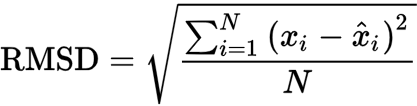

In [9]:
# Main function
def main(home_team, away_team):
    # Load and preprocess data
    matches, features = load_and_preprocess_data()

    # Split data for home and away goal prediction
    X_train, X_test, y_home_train, y_home_test = prepare_data(matches, features, 'FTHG')
    _, _, y_away_train, y_away_test = prepare_data(matches, features, 'FTAG')

    # Preprocessing pipeline
    preprocessor = create_preprocessor()
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    # Train models
    home_goal_model = train_random_forest(X_train, y_home_train)
    away_goal_model = train_random_forest(X_train, y_away_train)

    # Import models to joblib
    joblib.dump(home_goal_model, 'modelo_gb_local.pkl')
    joblib.dump(away_goal_model, 'modelo_gb_visitante.pkl')

    # Evaluate models
    y_home_pred = home_goal_model.predict(X_test)
    y_away_pred = away_goal_model.predict(X_test)

    print(f'Home Goal Prediction RMSE: {np.sqrt(mean_squared_error(y_home_test, y_home_pred))}')
    print(f'Away Goal Prediction RMSE: {np.sqrt(mean_squared_error(y_away_test, y_away_pred))}')
    print(f'Home Goal Prediction MSE: {mean_squared_error(y_home_test, y_home_pred)}')
    print(f'Away Goal Prediction MSE: {mean_squared_error(y_away_test, y_away_pred)}')


    # Calcular métricas
    metrics = {
      "Model": ["Random Forest"],
      "MSE": [mean_squared_error(y_home_test, y_home_pred), [mean_squared_error(y_away_test, y_away_pred)]],
    }

    # Example prediction
    historical_matches = matches.copy()
    result = predict_match(home_team, away_team, historical_matches, preprocessor, home_goal_model, away_goal_model)
    print(f'Match prediction: {result}')


In [10]:
if __name__ == "__main__":
    main('Man City', 'Liverpool')

Home Goal Prediction RMSE: 1.1341312083292332
Away Goal Prediction RMSE: 1.1637386701609789
Home Goal Prediction MSE: 1.2862535977063267
Away Goal Prediction MSE: 1.3542876924280438
Predicted goals: Man City 2 - 1 Liverpool
Match prediction: Man City wins


In [11]:
#### GRADIENT BOOSTING

In [12]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Reemplazar la función de entrenamiento con Gradient Boosting
def train_gradient_boosting(X_train, y_train):
    """
    Entrena un modelo de Gradient Boosting utilizando XGBoost.
    Args:
        X_train (array): Características de entrenamiento.
        y_train (array): Etiquetas de entrenamiento.
    Returns:
        model: Modelo entrenado.
    """
    model = XGBRegressor(
        n_estimators=100,  # Número de árboles
        learning_rate=0.1,  # Tasa de aprendizaje
        max_depth=6,       # Profundidad máxima de los árboles
        subsample=0.8,     # Submuestreo de filas
        colsample_bytree=0.8,  # Submuestreo de columnas
        random_state=42
    )
    model.fit(X_train, y_train)
    return model

In [13]:


# Main function adaptada para GB
def main(home_team, away_team):
    # Load and preprocess data
    matches, features = load_and_preprocess_data()

    # Split data for home and away goal prediction
    X_train, X_test, y_home_train, y_home_test = prepare_data(matches, features, 'FTHG')
    _, _, y_away_train, y_away_test = prepare_data(matches, features, 'FTAG')

    # Preprocessing pipeline
    preprocessor = create_preprocessor()
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    # Train Gradient Boosting models
    home_goal_model = train_gradient_boosting(X_train, y_home_train)
    away_goal_model = train_gradient_boosting(X_train, y_away_train)

    # Evaluate models
    y_home_pred = home_goal_model.predict(X_test)
    y_away_pred = away_goal_model.predict(X_test)

    # Evaluar el rendimiento utilizando RMSE
    home_rmse = np.sqrt(mean_squared_error(y_home_test, y_home_pred))
    home_mse = mean_squared_error(y_home_test, y_home_pred)
    away_rmse = np.sqrt(mean_squared_error(y_away_test, y_away_pred))
    away_mse = mean_squared_error(y_away_test, y_away_pred)
    print(f'Home Goal Prediction RMSE: {home_rmse}')
    print(f'Away Goal Prediction RMSE: {away_rmse}')
    print(f'Home Goal Prediction MSE: {home_mse}')
    print(f'Away Goal Prediction MSE: {away_mse}')
    # Example prediction
    historical_matches = matches.copy()
    result = predict_match(home_team, away_team, historical_matches, preprocessor, home_goal_model, away_goal_model)
    print(f'Match prediction: {result}')

# Llamada a la función principal
if __name__ == "__main__":
    main('Man City', 'Liverpool')


Home Goal Prediction RMSE: 1.125235588415877
Away Goal Prediction RMSE: 1.1588229142061308
Home Goal Prediction MSE: 1.2661551294376245
Away Goal Prediction MSE: 1.3428705464891895
Predicted goals: Man City 3 - 1 Liverpool
Match prediction: Man City wins


In [14]:
!python --version

Python 3.10.12
